In [1]:
import os
import json
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import random
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

In [2]:
def read_net(folder, graph_name):
    """Read network"""
    file_name = graph_name + '.net'
    G = nx.DiGraph(name = file_name)
    with open(os.path.join(folder, file_name), 'r', encoding='utf8') as f:
        f.readline()
        # add nodes
        for line in f:
            if line.startswith("*"):
                break
            else:
                node_info = line.split("\"")
                node = int(node_info[0]) - 1
                label = node_info[1]
                G.add_node(node, label=label)

        # add edges
        for line in f:
            node1_str, node2_str = line.split()[:2]
            G.add_edge(int(node1_str)-1, int(node2_str)-1)
    return G

In [3]:
EMBEDDING_FILENAME = os.path.join("..", "..", "data", "wikilinks_02.emb")
embeddings = np.genfromtxt(EMBEDDING_FILENAME, delimiter=',')

In [4]:
with open(os.path.join("..", "..", "data", 'page_categories.json'), 'r') as f:
    page_categories = json.load(f)

In [9]:
filename = "wikilinks_ids"
folder = os.path.join("..", "..", "data")
G = read_net(folder, filename)

In [6]:
def truncate_network(G, cutoff_views):
    with open("../../data/views_map.json", "r") as f:
        views = json.loads(f.read())
    views_set = set(views.keys())

    nodes_to_remove = []
    for node, label in G.nodes(data=True):
        if label["label"] in views_set:
            v = views[label["label"]]

            sum_views_of_page = 0
            for day in v:
                num_views = v[day]
                if num_views != None:
                    sum_views_of_page += num_views
            
            if sum_views_of_page < cutoff_views:
                nodes_to_remove.append(node)
    G.remove_nodes_from(nodes_to_remove)

In [7]:
truncate_network(G, cutoff_views=5)

In [10]:
pageid_to_nxid_map = defaultdict()

for node, label in dict(G.nodes(data=True)).items():
    pageid_to_nxid_map[label["label"]] = node

In [11]:
page_categories_updated = dict()
# pages = set(random.sample(list(pageid_to_nxid_map.keys()), 10000))
for i, vals in page_categories.items():
    # if str(i) in pages:
    page_categories_updated[pageid_to_nxid_map[i]] = vals
page_categories = dict(sorted(page_categories_updated.items()))

In [5]:
categories_set = set()
count = defaultdict(int)
for page, categories in page_categories.items():
    for category in categories:
        count[category[11:]] += 1
        categories_set.add(category[11:])

In [6]:
len(categories_set)

66288

In [9]:
for i, c in count.items():
    if c < 2:
        categories_set.remove(i)

In [10]:
len(categories_set)

40627

In [15]:
main_topics = [
    "Arhitektura",
    "Astronomija",
    "Biologija",
    "Človek",
    "Dogodki",
    "Družba",
    "Film",
    "Filozofija",
    "Fizika",
    "Geografija",
    "Glasba",
    "Izobraževanje",
    "Jezik",
    "Kemija",
    "Kmetijstvo",
    "Književnost",
    "Kultura",
    "Likovna umetnost",
    "Ljudje",
    "Matematika",
    "Narava",
    "Okolje",
    "Politika",
    "Posel",
    "Pravo",
    "Psihologija",
    "Religija",
    "Tehnika",
    "Umetnost",
    "Vojaštvo",
    "Zdravje",
    "Zgodovina",
    "Znanost"
]

In [16]:
for i in main_topics:
    if i in categories_set:
        categories_set.remove(i)

In [17]:
all_categories = main_topics
for i in list(categories_set):
    all_categories.append(i)

In [18]:
category_to_idx_map = defaultdict(int)
idx = 0
for i in all_categories:
    category_to_idx_map[i] = idx
    idx += 1

In [19]:
data_one_hot = np.zeros((len(page_categories), len(all_categories)), dtype=int)

In [20]:
idx_to_id_map = defaultdict(str)
idx = 0
for page, categories in page_categories.items():

    idx_to_id_map[idx] = page

    for category in categories:
        data_one_hot[idx][category_to_idx_map[category[11:]]] = 1

    idx += 1

In [36]:
n2v_embeddings = []
for page, categories in page_categories.items():
    n2v_embeddings.append(embeddings[page])
embeddings = np.array(n2v_embeddings)

In [58]:
pca_0 = PCA(n_components=2)
principalComponents_0 = pca_0.fit_transform(data_one_hot)
pca_1 = PCA(n_components=2)
principalComponents_1 = pca_1.fit_transform(embeddings)

In [59]:
data = []
for i in range(len(principalComponents_0)):
    data.append(np.concatenate((embeddings[i], principalComponents_0[i]), axis=0))
data = np.array(data)

In [39]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)

In [93]:
a = principalComponents_1[np.random.choice(principalComponents_1.shape[0], 10000, replace=False), :]

In [98]:
clustering = KMeans(n_clusters=20).fit_predict(a)
# clustering = AgglomerativeClustering(n_clusters=5, linkage="average", affinity="cosine").fit_predict(a)
# clustering = Birch(threshold=0.000001, n_clusters=5).fit_predict(a)
# clustering = GaussianMixture(n_components=10).fit_predict(a)
# clustering = SpectralClustering(n_clusters=2).fit_predict(a)

In [99]:
colors = ["#ff71ce", "#01cdfe", "#05ffa1", "#b967ff", "#fffb96", "#2e4d24", "#afb3b0", "#e38421", "#b3caa9", "#c53a48", "#650871", "#f69284", "#231f20", "#95b8e3", "#c095e3", "#f0b892", "#987d84", "#a99887", "#587a8f", "#ffbdbd", "#e3adb5", "#929195", "#95b8e3", "#95dfe3"]
c = []
for i in clustering:
    c.append(colors[i])

In [100]:
principalDf = pd.DataFrame(data = a, columns = ['principal component 1', 'principal component 2'])

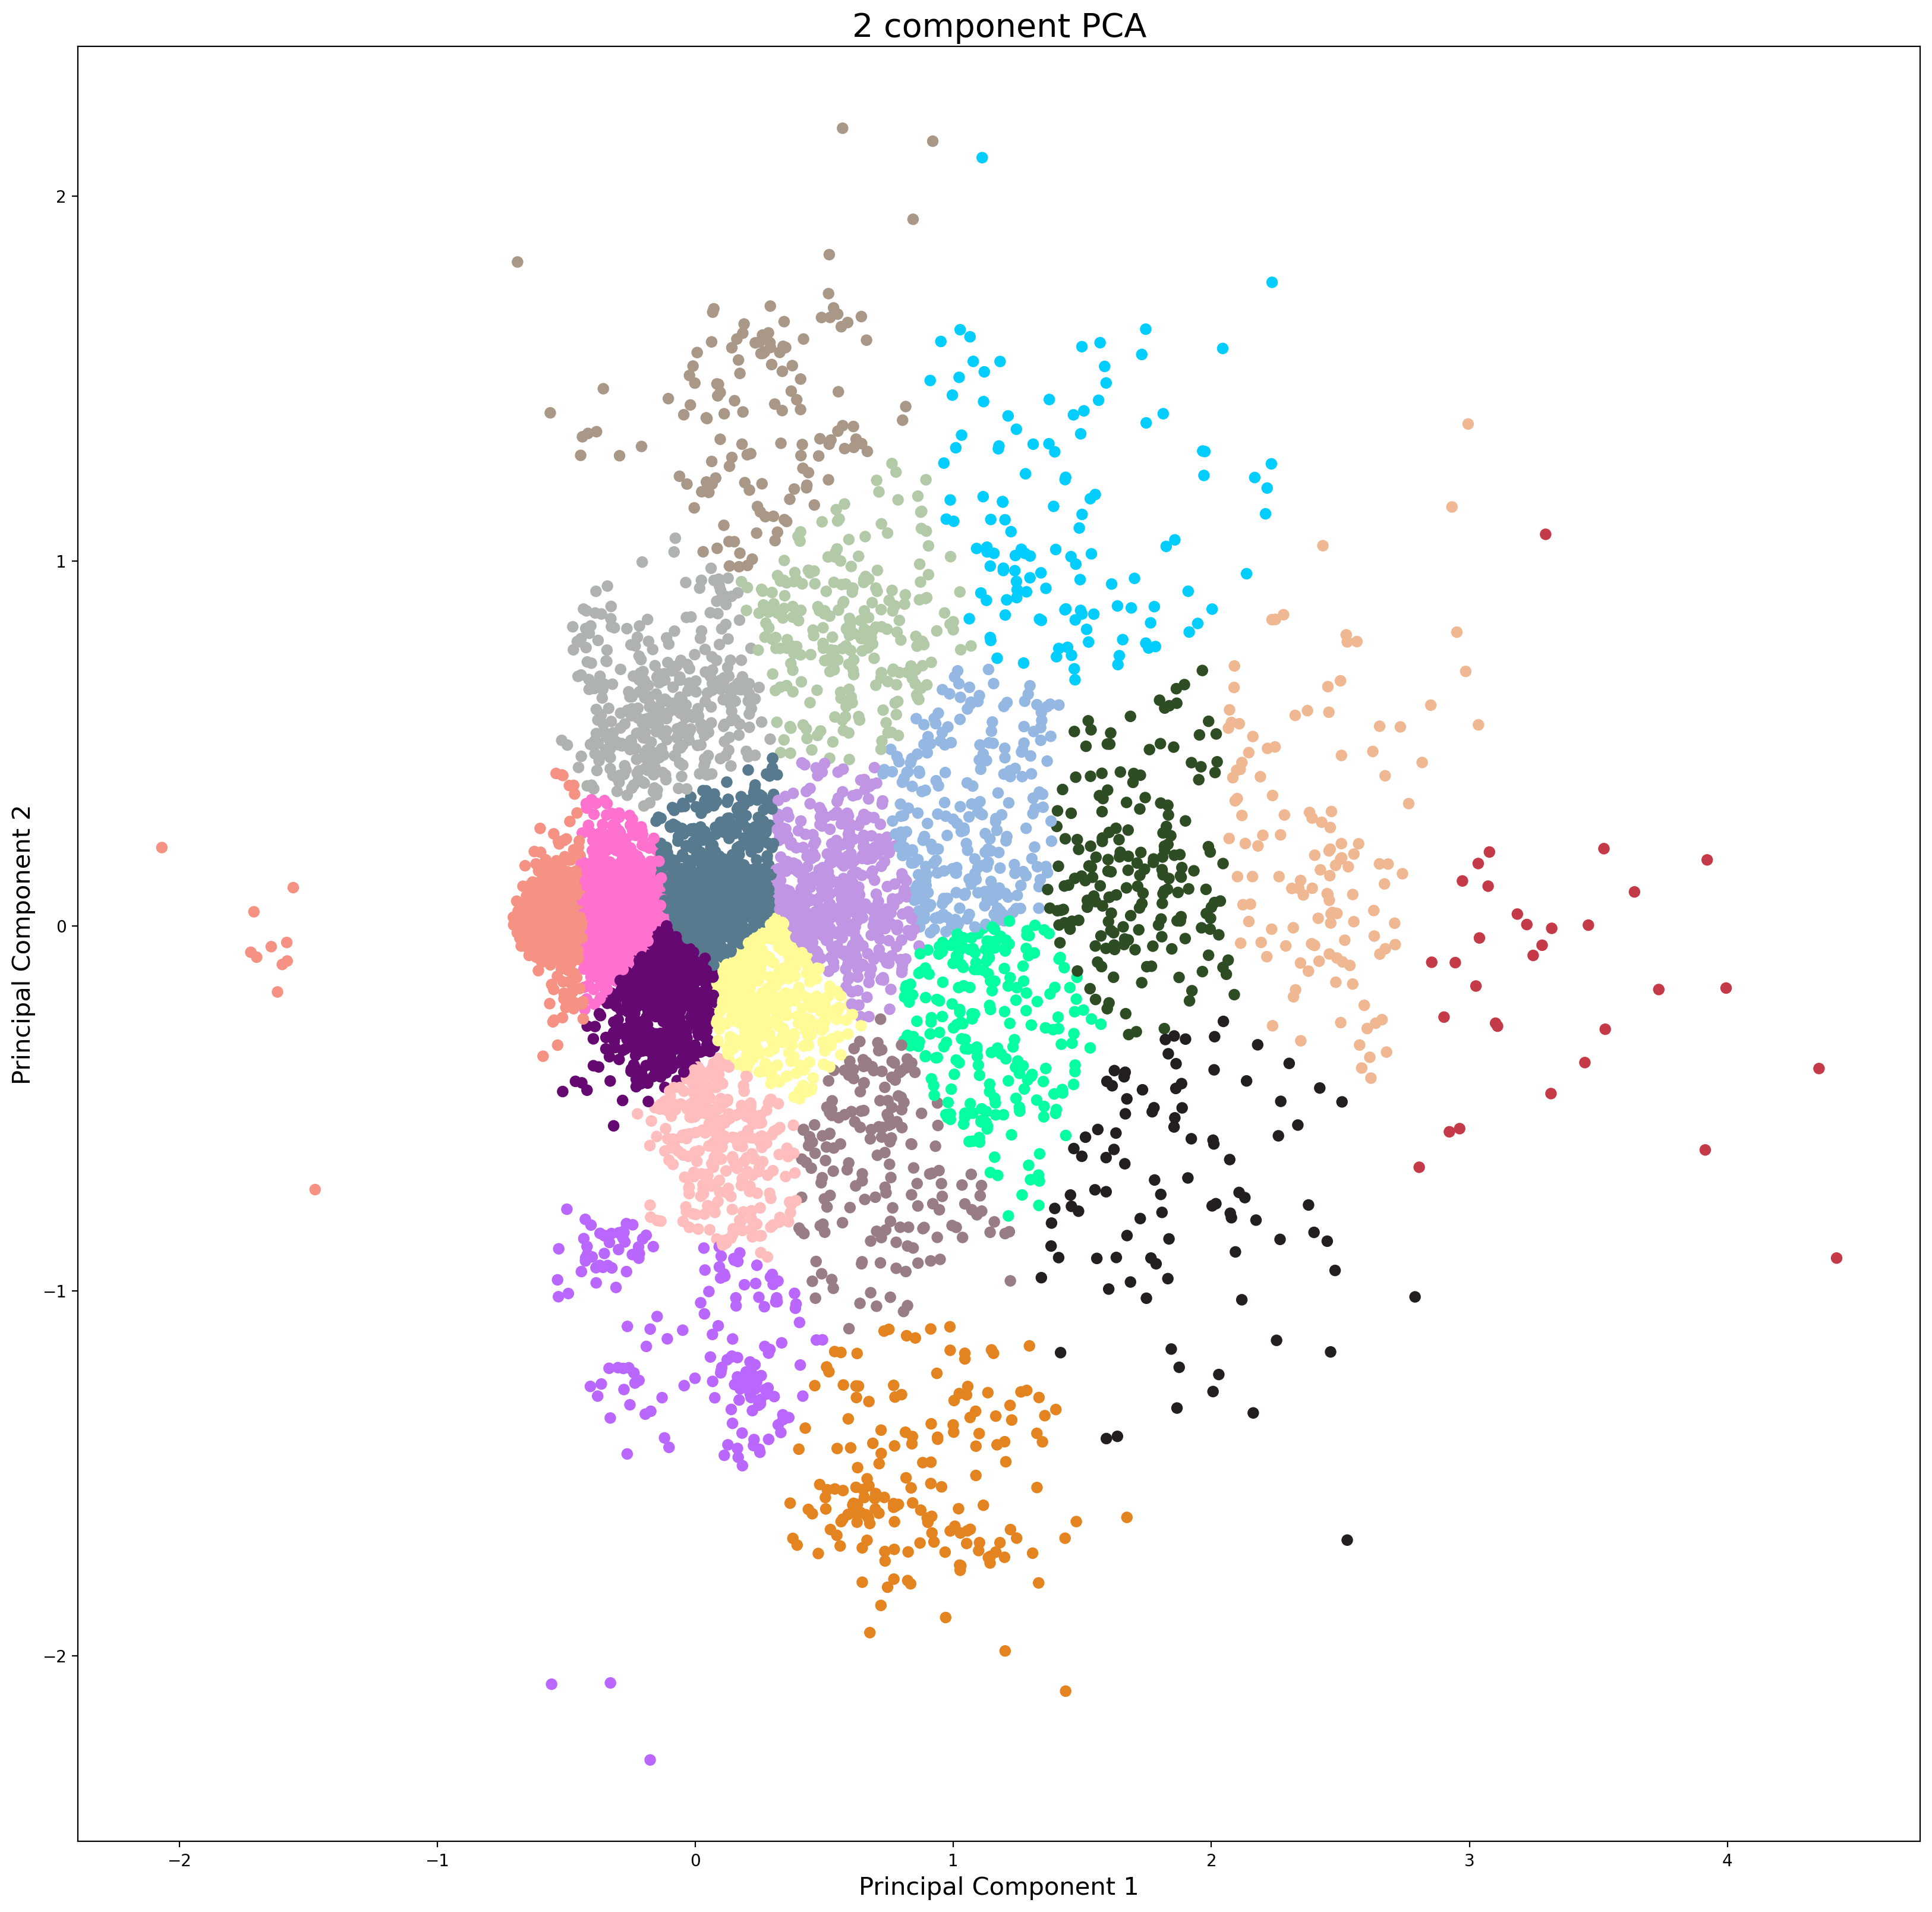

In [101]:
fig = plt.figure(figsize = (20,20), facecolor="white", dpi=200)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=c)

plt.show()